In [166]:
import pynwb
import os

#DataJoint and DataJoint schema
import datajoint as dj
import numpy as np

## We also import a bunch of tables so that we can call them easily

from nwb_datajoint.common import (RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  FirFilter,
                                  IntervalList,
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session, ExperimenterList,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery,
                                  get_electrode_indices)
from nwb_datajoint.common.common_position import (PositionInfoParameters,IntervalPositionInfo)

from plot_lfp import (get_x_y_timestamp_list)#, get_speed, get_timestamps_and_data,get_electrode_ids,remove_dead_tet_chans,check_for_dead_probes,
#                       checking_other_dead_tets,simple_plot,plot_overlay,plot_speed_versus_theta)

import re
import matplotlib.pyplot as plt
import warnings
from ripple_detection.detectors import Kay_ripple_detector

warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

In [118]:
nwb_file_name = 'senor20201030_.nwb'



In [119]:
Kay_ripple_detector?
#As you can see, the detector requires:
#time (n_time)
#ripple filtered LFP (with the same time) 
#speed (with the same time) 
#and then a bunch of thresholds/ values. 
#but the part Im suspicious about is the times. 

#only 1 time so only 1 sampling freq
#what are the pos/speed sampling rates? 

Signature:
Kay_ripple_detector(
    time,
    filtered_lfps,
    speed,
    sampling_frequency,
    speed_threshold=4.0,
    minimum_duration=0.015,
    zscore_threshold=2.0,
    smoothing_sigma=0.004,
    close_ripple_threshold=0.0,
)
Docstring:
Find start and end times of sharp wave ripple events (150-250 Hz)
based on Kay et al. 2016 [1].

Parameters
----------
time : array_like, shape (n_time,)
filtered_lfps : array_like, shape (n_time, n_signals)
    Bandpass filtered time series of electric potentials in the ripple band
speed : array_like, shape (n_time,)
    Running speed of animal
sampling_frequency : float
    Number of samples per second.
speed_threshold : float, optional
    Maximum running speed of animal for a ripple
minimum_duration : float, optional
    Minimum time the z-score has to stay above threshold to be
    considered a ripple. The default is given assuming time is in
    units of seconds.
zscore_threshold : float, optional
    Number of standard deviations the ri

In [120]:
#get sampling rate of lfp (though is this the same 
lfp_sampling_rate = (LFPBand & {'nwb_file_name' : nwb_file_name,
                               'filter_name' : 'Ripple 150-250 Hz'}).fetch('lfp_band_sampling_rate')
lfp_sampling_rate


array([1000])

In [121]:

# Get animal speed upsampled to LFP sampling rate
lfp_pos_df = (IntervalPositionInfo & {'nwb_file_name' : nwb_file_name,
                                      'interval_list_name' : 'pos 0 valid times',
                                      'position_info_param_name' : 'default_lfp'}).fetch1_dataframe()
lfp_pos_df
#diff the times, make sure theyre 1ms apart 

head_position_x  head_position_y  head_orientation  \
time                                                               
1.604075e+09        27.200000        34.200000          1.417409   
1.604075e+09        27.206618        34.200368          1.906635   
1.604075e+09        27.213235        34.200735          2.014282   
1.604075e+09        27.219853        34.201103          2.021347   
1.604075e+09        27.226471        34.201471          2.019686   
...                       ...              ...               ...   
1.604077e+09        23.809314        19.357353         -1.397712   
1.604077e+09        23.809069        19.357598         -1.396753   
1.604077e+09        23.808824        19.357843         -1.362780   
1.604077e+09        23.808578        19.358088         -0.948130   
1.604077e+09        23.808333        19.358333          0.910444   

              head_velocity_x  head_velocity_y  head_speed  
time                                                        
1.604075e+09         1.723381         0.060225    1.724433  
1.604075e+09         1.734487         0.060768    1.735551  
1.604075e+09         1.745569         0.061316    1.746646  
1.604075e+09         1.756627         0.061869    1.757716  
1.604075e+09         1.767658         0.062427    1.768760  
...                       ...              ...         ...  
1.604077e+09        -0.039023         0.052837    0.065685  
1.604077e+09        -0.038728         0.052494    0.065234  
1.604077e+09        -0.038436         0.052150    0.064784  
1.604077e+09        -0.038145         0.051806    0.064334  
1.604077e+09        -0.037856         0.051461    0.063885  

[2356506 rows x 6 columns]

In [122]:
PositionInfoParameters()# & {'nwb_file_name' : nwb_file_name}

*position_info max_separation max_speed     position_smoot speed_smoothin head_orient_sm led1_is_front  is_upsampled   upsampling_sam upsampling_int
+------------+ +------------+ +-----------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
default        9.0            300.0         0.125          0.1            0.001          1              0              nan            linear        
default_decodi 9.0            300.0         0.125          0.1            0.001          1              1              500.0          linear        
default_lfp    9.0            300.0         0.125          0.1            0.001          1              1              1000.0         linear        
 (Total: 3)

In [165]:
IntervalPositionInfo()

#So i can interpolate and reindex either the pos or the lfp at this stage, or recreate a valid time that is the itnersection of the two earlier on, but con is that its copying data 


*position_info *nwb_file_name *interval_list analysis_file_ head_position_ head_orientati head_velocity_
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
default        chimi20200216_ pos 1 valid ti chimi20200216_ 92a087ca-3df6- 65199939-b878- a876e869-4eb5-
default        fern20211007_. pos 0 valid ti fern20211007_W b6079197-7667- ff8a164a-51a9- a2bb89e1-690e-
default        fern20211007_. pos 1 valid ti fern20211007_K ad1b7a41-ace1- e83852be-bf00- aa2f3c23-420a-
default        fern20211007_. pos 10 valid t fern20211007_2 7704fa04-c324- 1975cecc-e05f- 69c976b0-9a20-
default        fern20211007_. pos 11 valid t fern20211007_X f29c7f68-0547- 147586f9-b123- e180a55b-33f6-
default        fern20211007_. pos 12 valid t fern20211007_8 eb34a14c-b198- 30504e92-0471- ee6dc74a-8763-
default        fern20211007_. pos 13 valid t fern20211007_7 b899060d-83af- 1e505332-4e09- 98e0b073-6743-
default        fern20211007_. pos 14 valid t fern20211007_R adcb8bdb-caf2- 60dcd812-df51- 81816d8a-764c-
default        fern20211007_. pos 15 valid t fern20211007_X 81605410-00f0- 1472a26c-6dce- 2e4dc0fe-f4d9-
default        fern20211007_. pos 16 valid t fern20211007_E ac5a7e38-63ac- f4d83128-a55a- af49e940-ca17-
default        fern20211007_. pos 17 valid t fern20211007_A 44d7b2b9-0992- dcb26b45-40b9- 0b4fbdcb-04c5-
default        fern20211007_. pos 18 valid t fern20211007_9 6ac5dde3-9c42- e8db80f9-78e6- 1f6346b3-4492-
   ...
 (Total: 450)

In [123]:
# Head speed in cm/s - because that is a param of the ripple detection detection 
head_speed = np.asarray(lfp_pos_df.head_speed)
head_speed 

array([1.72443293, 1.73555143, 1.74664597, ..., 0.06478392, 0.06433412,
       0.06388498])

In [124]:
np.shape(head_speed)

(2356506,)

In [125]:
# Position timestamps in s
pos_time = lfp_pos_df.index

In [126]:
np.shape(pos_time)

(2356506,)

In [129]:
# Get ripple-filtered LFP
lfp_ripple_object = (LFPBand & {'nwb_file_name' : nwb_file_name,
                                'filter_name' : 'Ripple 150-250 Hz'}).fetch_nwb()[0]

lfp_ripple_object['filtered_data']

filtered data pynwb.ecephys.ElectricalSeries at 0x139972803095232
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (23870418, 89), type "<i2">
  description: no description
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  interval: 1
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (23870418,), type "<f8">
  timestamps_unit: seconds
  unit: volts

In [130]:
lfp_ripple = np.asarray( lfp_ripple_object['filtered_data'].data, dtype='double' )

lfp_ripple

array([[  1.,   6.,   2., ...,  -6.,  -6., -11.],
       [ 27.,  13.,   8., ..., -18., -21., -25.],
       [ 15.,  -3.,   0., ...,  -6.,  -9.,  -5.],
       ...,
       [ -9., -20.,   4., ...,  16.,   4.,   5.],
       [ -2.,  -5.,   7., ..., -10., -20., -19.],
       [  8.,  15.,   0., ..., -32., -28., -28.]])

In [131]:
np.shape(lfp_ripple)

(23870418, 89)

In [132]:
lfp_time = lfp_ripple_object['filtered_data'].timestamps[:]
lfp_time

array([1.60407482e+09, 1.60407482e+09, 1.60407482e+09, ...,
       1.60410594e+09, 1.60410594e+09, 1.60410594e+09])

In [133]:
np.shape(lfp_time)

(23870418,)

Text(0.5, 1.0, 'original lfp and pos times that we want to align')

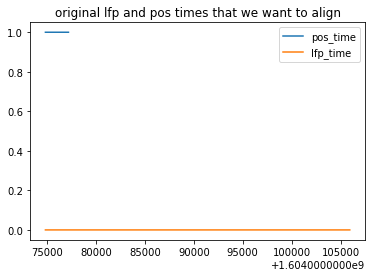

In [134]:
plt.plot(pos_time,np.ones(len(pos_time)),label = 'pos_time' )
plt.plot(lfp_time, np.zeros(len(lfp_time)), label= 'lfp_time')
plt.legend()
plt.title('original lfp and pos times that we want to align')

In [29]:
#Now, we need to find the overlap between the lfp times and position times, and only include the times that occur on both. 

In [135]:
def find_overlapping_times(data_list, interval_list=None):
    #this function will take datasets with different times(data_list), and will mask it based on interval_list
    #
    if interval_list is None:
        raise NotImplementedError
    
    else:
        ind_list = [None]*len(data_list)
        for ndx, data in enumerate(data_list):
            ind = np.full(data.size, False)
            for interval in interval_list:
                start_idx = np.where(data >= interval[0])[0][0]
                end_idx = np.where(data <= interval[1])[0][-1]
                ind[start_idx:end_idx+1] = True
            ind_list[ndx] = ind
    return ind_list

#This function: in the else... makes an empty list the length of 

In [136]:
data_list=[pos_time, lfp_time]

In [137]:
ind_list = [None]*len(data_list)
ind_list

[None, None]

In [139]:
for ndx, data in enumerate(data_list):
    ind = np.full(data.size, False)
print(len(ind))
ind

23870418


array([False, False, False, ..., False, False, False])

In [140]:
interval_list = overlap_interval_list

In [141]:
interval_list

array([[1.60407482e+09, 1.60407482e+09],
       [1.60407482e+09, 1.60407718e+09]])

In [142]:
for interval in interval_list:
    #Since interval list has two intervals, its saying we want the times from the very beginning to the very end of all lists. 
    start_idx = np.where(data >= interval[0])[0][0]
    end_idx = np.where(data <= interval[1])[0][-1]
    ind[start_idx:end_idx+1] = True # not sure why he adds the plus one. 
ind_list[ndx] = ind

In [143]:
np.where(data >= interval[0])[0][0]

819

In [144]:
np.where(data <= interval[1])[0][-1]

2356415

In [145]:
2356415-819

2355596

In [146]:
len(ind)

23870418

In [147]:
sum(ind)

2355788

In [34]:
# so first we need the itnervals from lfp and form position times to input as data_list. 
lfp_interval_list = (IntervalList & {'nwb_file_name' : nwb_file_name,
                                     'interval_list_name' : 'lfp valid times'}).fetch1('valid_times')
lfp_interval_list


array([[1.60407482e+09, 1.60407718e+09],
       [1.60407821e+09, 1.60407941e+09],
       [1.60408002e+09, 1.60408210e+09],
       [1.60408303e+09, 1.60408417e+09],
       [1.60408450e+09, 1.60408632e+09],
       [1.60408665e+09, 1.60408703e+09],
       [1.60408703e+09, 1.60408781e+09],
       [1.60408801e+09, 1.60409005e+09],
       [1.60409063e+09, 1.60409179e+09],
       [1.60409198e+09, 1.60409202e+09],
       [1.60409202e+09, 1.60409381e+09],
       [1.60409420e+09, 1.60409490e+09],
       [1.60409490e+09, 1.60409501e+09],
       [1.60409501e+09, 1.60409523e+09],
       [1.60409523e+09, 1.60409528e+09],
       [1.60409545e+09, 1.60409768e+09],
       [1.60409828e+09, 1.60409941e+09],
       [1.60409967e+09, 1.60410165e+09],
       [1.60410256e+09, 1.60410304e+09],
       [1.60410304e+09, 1.60410357e+09],
       [1.60410427e+09, 1.60410460e+09],
       [1.60410460e+09, 1.60410594e+09]])

In [148]:
position_interval_list = (IntervalList & {'nwb_file_name' : nwb_file_name,
                                          'interval_list_name' : 'pos 0 valid times'}).fetch1('valid_times')

position_interval_list

array([[1.60407482e+09, 1.60407482e+09],
       [1.60407482e+09, 1.60407718e+09]])

In [149]:
from nwb_datajoint.common.common_interval import interval_list_intersect


overlap_interval_list = interval_list_intersect(lfp_interval_list, position_interval_list)
#"finds the intersection between two interval lists' - I feel like there should be an easier way to mask the data without using the function.

#Then we need to find their overlap, which is what interval_list_intersect does. 
overlap_interval_list #appears they overlap for most, if not all of position_interval_list. 

array([[1.60407482e+09, 1.60407482e+09],
       [1.60407482e+09, 1.60407718e+09]])

In [150]:
overlap_interval_list #the first entry is super short! 

array([[1.60407482e+09, 1.60407482e+09],
       [1.60407482e+09, 1.60407718e+09]])

In [167]:
pos_ind, lfp_ind = find_overlapping_times([pos_time, lfp_time], overlap_interval_list)


In [185]:
pos_time[pos_ind]

Float64Index([1604074821.9790099, 1604074821.9800098,   1604074821.98101,
                1604074821.98201, 1604074821.9830098,   1604074821.98401,
                1604074821.98501, 1604074821.9860098, 1604074821.9870098,
                1604074821.98801,
              ...
               1604077178.393186,  1604077178.394186,  1604077178.395186,
               1604077178.396186,  1604077178.397186,  1604077178.398186,
              1604077178.3991861,  1604077178.400186,  1604077178.401186,
              1604077178.4021862],
             dtype='float64', name='time', length=2355797)

In [186]:
lfp_time[lfp_ind]

array([1.60407482e+09, 1.60407482e+09, 1.60407482e+09, ...,
       1.60407718e+09, 1.60407718e+09, 1.60407718e+09])

In [203]:
print(len(pos_time[pos_ind]))
print(len(lfp_time[lfp_ind]))

2355797
2355788


In [254]:
pos_time[pos_ind]

Float64Index([1604074821.9790099, 1604074821.9800098,   1604074821.98101,
                1604074821.98201, 1604074821.9830098,   1604074821.98401,
                1604074821.98501, 1604074821.9860098, 1604074821.9870098,
                1604074821.98801,
              ...
               1604077178.393186,  1604077178.394186,  1604077178.395186,
               1604077178.396186,  1604077178.397186,  1604077178.398186,
              1604077178.3991861,  1604077178.400186,  1604077178.401186,
              1604077178.4021862],
             dtype='float64', name='time', length=2355797)

In [260]:
position_df = pd.DataFrame(pos_time[pos_ind],index =pos_time[pos_ind] )
position_df['speed']= head_speed[pos_ind]

# position_df.time
position_df

time     speed
time                                
1.604075e+09  1.604075e+09  2.172682
1.604075e+09  1.604075e+09  2.182202
1.604075e+09  1.604075e+09  2.191675
1.604075e+09  1.604075e+09  2.201098
1.604075e+09  1.604075e+09  2.210473
...                    ...       ...
1.604077e+09  1.604077e+09  0.083183
1.604077e+09  1.604077e+09  0.082717
1.604077e+09  1.604077e+09  0.082251
1.604077e+09  1.604077e+09  0.081785
1.604077e+09  1.604077e+09  0.081319

[2355797 rows x 2 columns]

In [218]:
# np.array(pos_time[pos_ind])

array([1.60407482e+09, 1.60407482e+09, 1.60407482e+09, ...,
       1.60407718e+09, 1.60407718e+09, 1.60407718e+09])

0          1.604075e+09
1          1.604075e+09
2          1.604075e+09
3          1.604075e+09
4          1.604075e+09
               ...     
2355792    1.604077e+09
2355793    1.604077e+09
2355794    1.604077e+09
2355795    1.604077e+09
2355796    1.604077e+09
Name: 0, Length: 2355797, dtype: float64

In [261]:
new_index = pd.Index(np.unique(np.concatenate(
                (position_df.time, lfp_time[lfp_ind]))), name='time1')

new_index

Float64Index([1604074821.9785376, 1604074821.9790099, 1604074821.9795377,
              1604074821.9800098, 1604074821.9805377,   1604074821.98101,
              1604074821.9815376,   1604074821.98201, 1604074821.9825377,
              1604074821.9830098,
              ...
               1604077178.398186, 1604077178.3982491, 1604077178.3991861,
              1604077178.3992493,  1604077178.400186, 1604077178.4002492,
               1604077178.401186, 1604077178.4012492, 1604077178.4021862,
               1604077178.402249],
             dtype='float64', name='time1', length=4710986)

In [262]:
new_index = pd.Index(np.unique(np.concatenate(
                (position_df.time, lfp_time[lfp_ind]))), name='time1')

new_index

speed_df = (position_df.reindex(index=new_index)
               .interpolate(method='linear')
               .reindex(index=lfp_time[lfp_ind]))
speed_df

time     speed
time1                               
1.604075e+09           NaN       NaN
1.604075e+09  1.604075e+09  2.177442
1.604075e+09  1.604075e+09  2.186939
1.604075e+09  1.604075e+09  2.196387
1.604075e+09  1.604075e+09  2.205786
...                    ...       ...
1.604077e+09  1.604077e+09  0.082950
1.604077e+09  1.604077e+09  0.082484
1.604077e+09  1.604077e+09  0.082018
1.604077e+09  1.604077e+09  0.081552
1.604077e+09  1.604077e+09  0.081319

[2355788 rows x 2 columns]

In [267]:
speed_df.time.index

Float64Index([1604074821.9785376, 1604074821.9795377, 1604074821.9805377,
              1604074821.9815376, 1604074821.9825377, 1604074821.9835377,
              1604074821.9845376, 1604074821.9855378, 1604074821.9865377,
              1604074821.9875376,
              ...
              1604077178.3932493, 1604077178.3942492, 1604077178.3952494,
              1604077178.3962493, 1604077178.3972492, 1604077178.3982491,
              1604077178.3992493, 1604077178.4002492, 1604077178.4012492,
               1604077178.402249],
             dtype='float64', name='time1', length=2355788)

In [ ]:
speed_df.speed.to_list()

# .iloc[0:len(speed_df)].to_list()

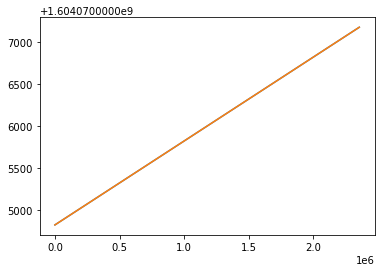

In [284]:
plt.plot(speed_df.speed.index)
plt.plot(lfp_time[lfp_ind])

In [285]:
speed_df.speed.index[0]

1604074821.9785376

In [286]:
lfp_time[lfp_ind][0]

1604074821.9785376

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [198]:
position_df.index

Float64Index([1604074821.9785376, 1604074821.9795377, 1604074821.9805377,
              1604074821.9815376, 1604074821.9825377, 1604074821.9835377,
              1604074821.9845376, 1604074821.9855378, 1604074821.9865377,
              1604074821.9875376,
              ...
              1604077178.3932493, 1604077178.3942492, 1604077178.3952494,
              1604077178.3962493, 1604077178.3972492, 1604077178.3982491,
              1604077178.3992493, 1604077178.4002492, 1604077178.4012492,
               1604077178.402249],
             dtype='float64', name='time', length=2355788)

In [201]:
pos_ind, lfp_ind = find_overlapping_times([pos_time, lfp_time], overlap_interval_list)

2356506

In [184]:
position_df.iloc[1][0]

1604077178.4021862

Text(0.5, 1.0, 'aligned times- pos and lfp times')

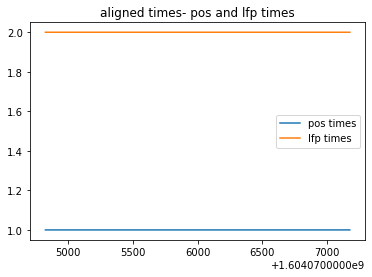

In [152]:
plt.plot(pos_time[pos_ind], np.ones(len(pos_time[pos_ind])),label = 'pos times')
plt.plot(lfp_time[lfp_ind],np.ones(len(lfp_time[lfp_ind]))*2,label = 'lfp times')
plt.legend()
plt.title('aligned times- pos and lfp times')
#looks like theyre roughly the same 

In [108]:
pos_time[pos_ind] - lfp_time[lfp_ind]

ValueError: operands could not be broadcast together with shapes (2355797,) (2355788,) 

In [153]:
len(pos_time[pos_ind])

2355797

In [154]:
len(lfp_time[lfp_ind]) #but not exact. important, which to use? 

2355788

In [155]:
lfp_electrode_ids = lfp_ripple_object['filtered_data'].electrodes[:].index
electrode_groups = [(Electrode() & {'nwb_file_name' : nwb_file_name,
                                    'electrode_id' : lfp_electrode}).fetch1('electrode_group_name')
                     for lfp_electrode in lfp_electrode_ids]

tetrode_ind = np.asarray( [int(group_name) <= 23 for group_name in electrode_groups] )
tetrode_ind[[4, 5, 17]] = False
tetrode_ind
#This will give us all the tetrodes, minus the references, that we will detect ripples across 


array([ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [156]:
ripple_elecs = lfp_electrode_ids[tetrode_ind]

In [157]:
# lfp_ripple = lfp_ripple[lfp_align_ind, :]
# lfp_ripple[:, tetrode_ind]


ripple_data_ind = np.ix_(lfp_ind, tetrode_ind)
np.shape(ripple_data_ind[0])


(2355788, 1)

In [158]:
print(pos_time[pos_ind][0], pos_time[pos_ind][-1])
# print(lfp_time[pos_ind][0], lfp_time[pos_ind][-1])
print(lfp_time[lfp_ind][0], lfp_time[lfp_ind][-1])

1604074821.9790099 1604077178.4021862
1604074821.9785376 1604077178.402249


In [159]:
print(pos_time[pos_ind][-1] - pos_time[pos_ind][0])
print(lfp_time[lfp_ind][-1]-lfp_time[lfp_ind][0])

2356.4231762886047
2356.423711538315


In [160]:
pos_time[pos_ind][0]-lfp_time[lfp_ind][0]

0.0004723072052001953

In [161]:
lfp_time[lfp_ind]
len(lfp_time[lfp_ind])

2355788

In [320]:
np.array(speed_df.speed.to_list())

array([       nan, 2.17744229, 2.18693855, ..., 0.08201804, 0.08155226,
       0.08131941])

In [321]:
ripple_times_df = Kay_ripple_detector(lfp_time[lfp_ind],
                                      lfp_ripple[lfp_ind],
                                      np.array(speed_df.speed.to_list()),
                                      lfp_sampling_rate,
                                      speed_threshold=4.0,
                                      minimum_duration=0.015,
                                      zscore_threshold=2.0,
                                      smoothing_sigma=0.004,
                                      close_ripple_threshold=0.0)
#

In [322]:
ripple_times_df

start_time      end_time
ripple_number                            
1              1.604075e+09  1.604075e+09
2              1.604075e+09  1.604075e+09
3              1.604075e+09  1.604075e+09
4              1.604075e+09  1.604075e+09
5              1.604075e+09  1.604075e+09
...                     ...           ...
1064           1.604077e+09  1.604077e+09
1065           1.604077e+09  1.604077e+09
1066           1.604077e+09  1.604077e+09
1067           1.604077e+09  1.604077e+09
1068           1.604077e+09  1.604077e+09

[1068 rows x 2 columns]

In [304]:
(speed_df.speed)

time1
1.604075e+09         NaN
1.604075e+09    2.177442
1.604075e+09    2.186939
1.604075e+09    2.196387
1.604075e+09    2.205786
                  ...   
1.604077e+09    0.082950
1.604077e+09    0.082484
1.604077e+09    0.082018
1.604077e+09    0.081552
1.604077e+09    0.081319
Name: speed, Length: 2355788, dtype: float64

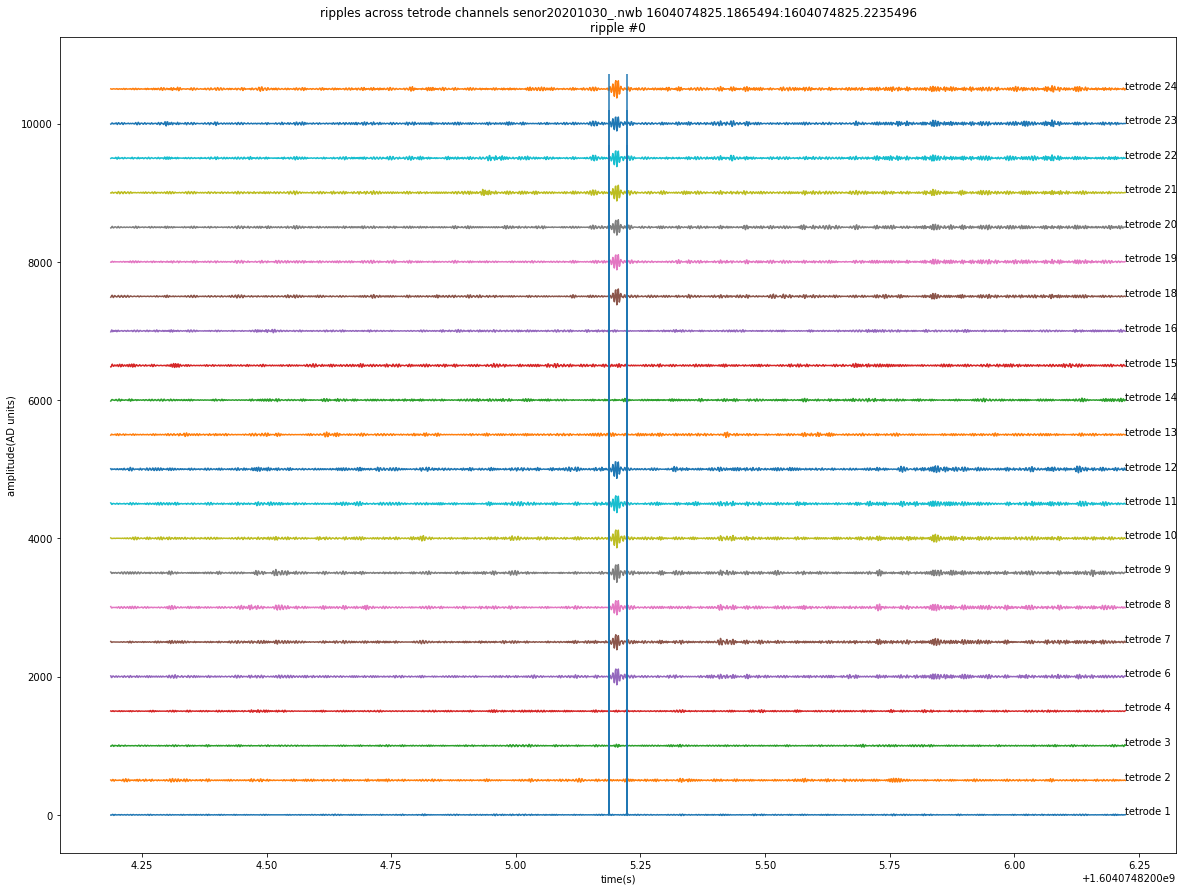

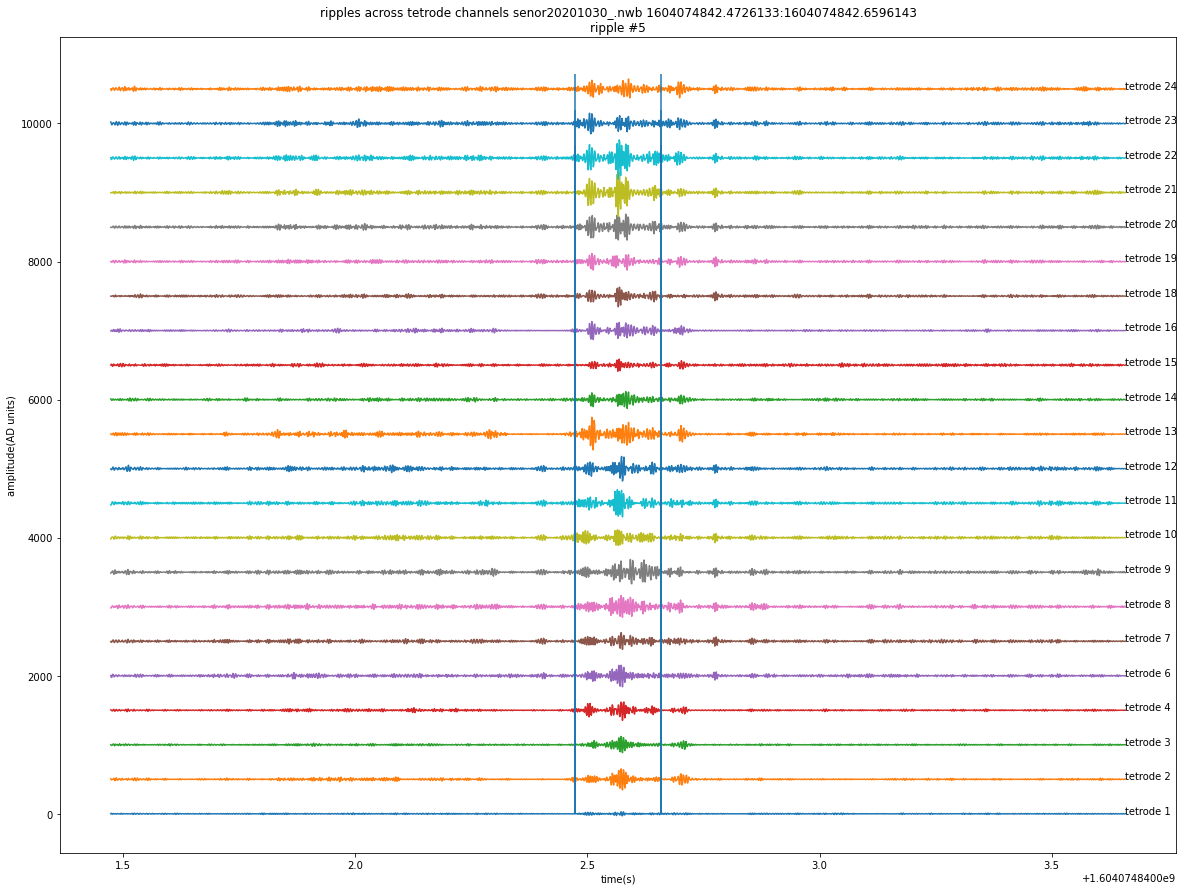

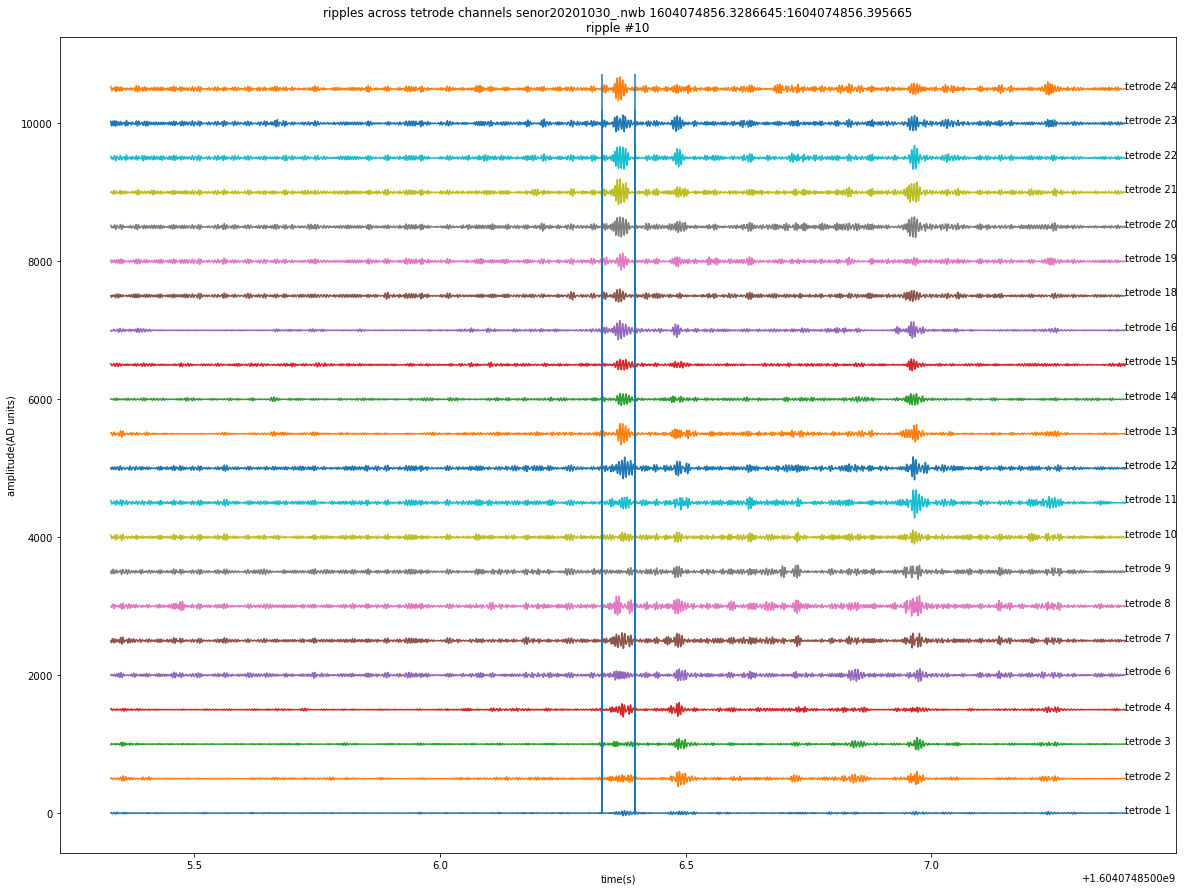

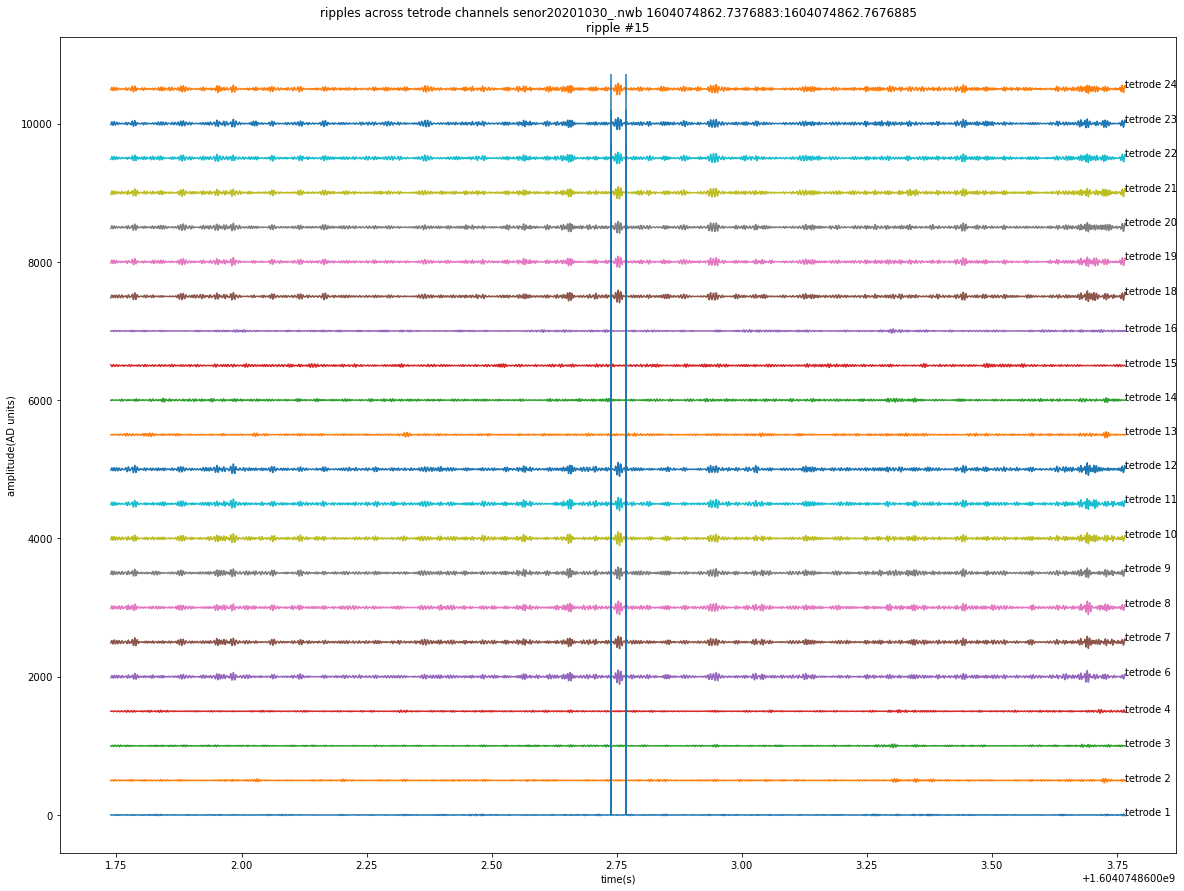

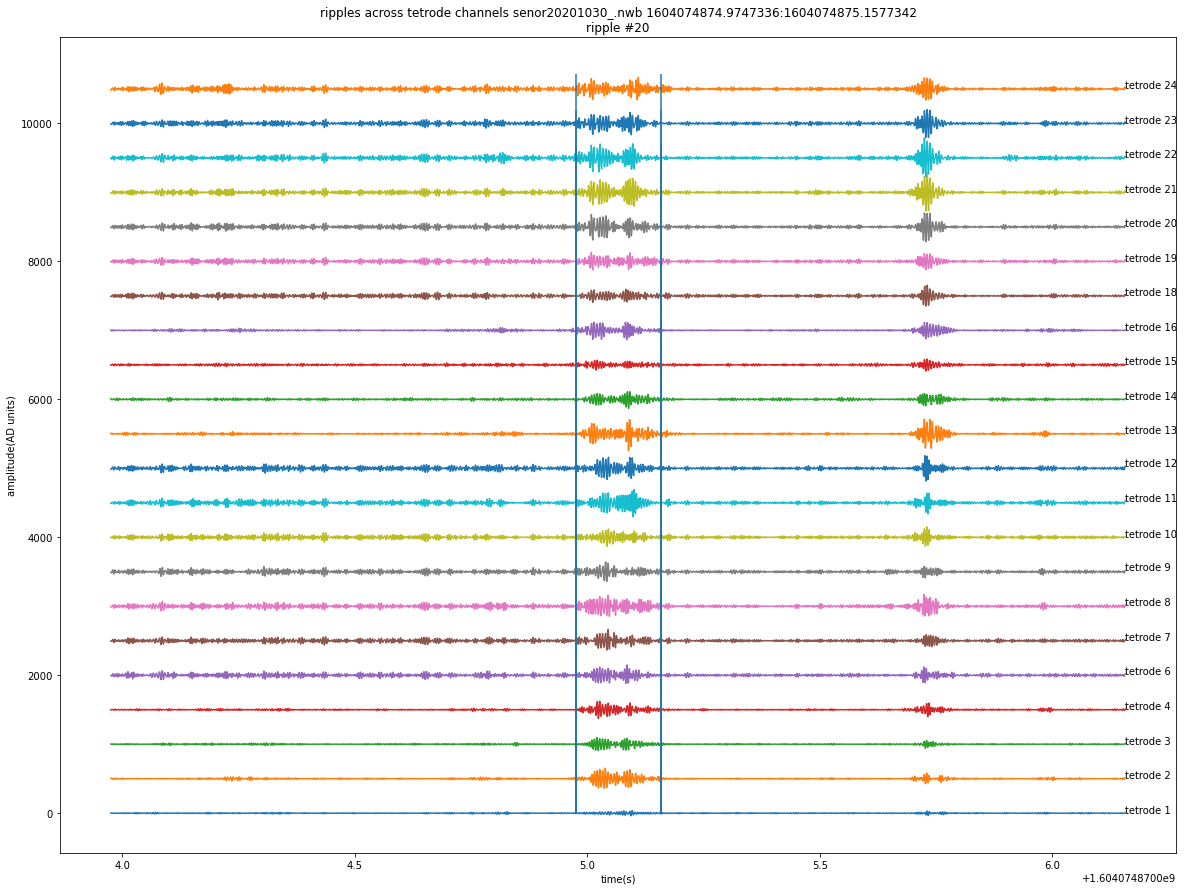

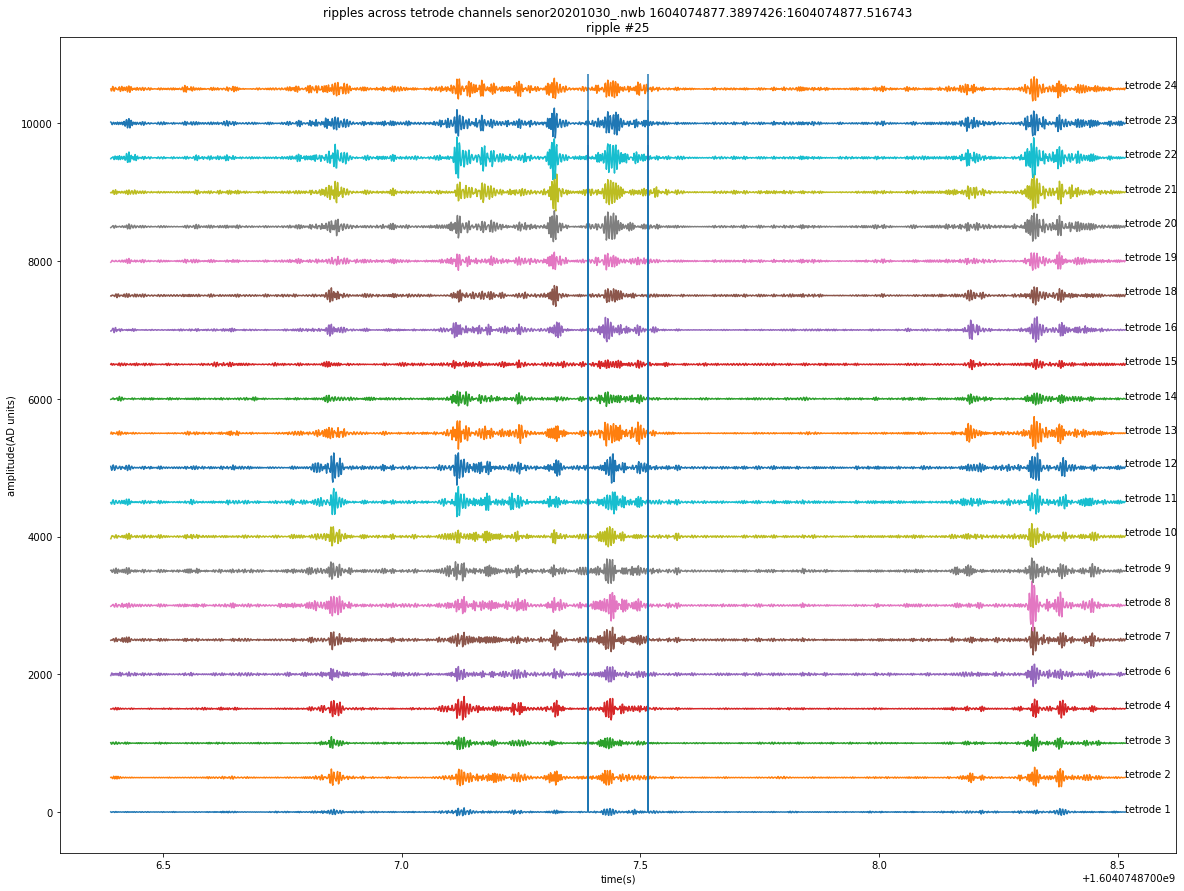

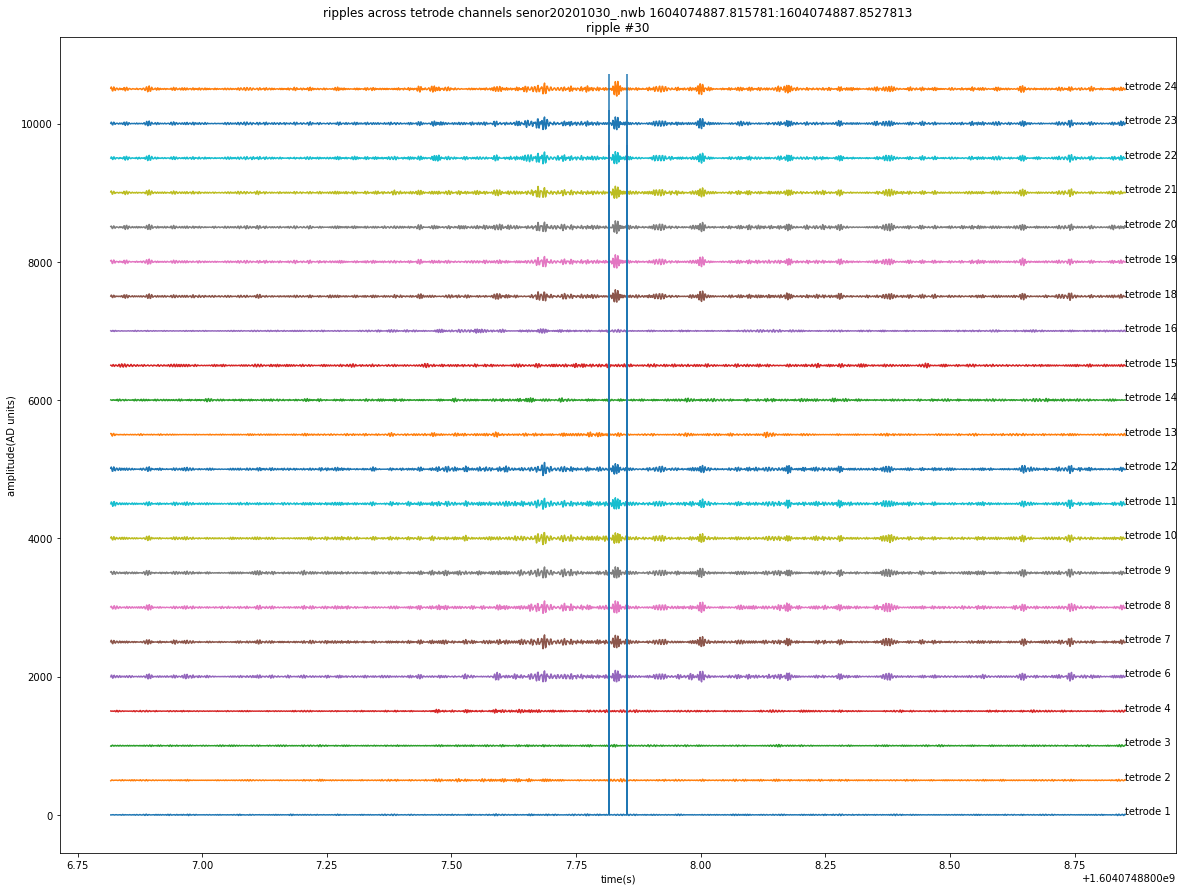

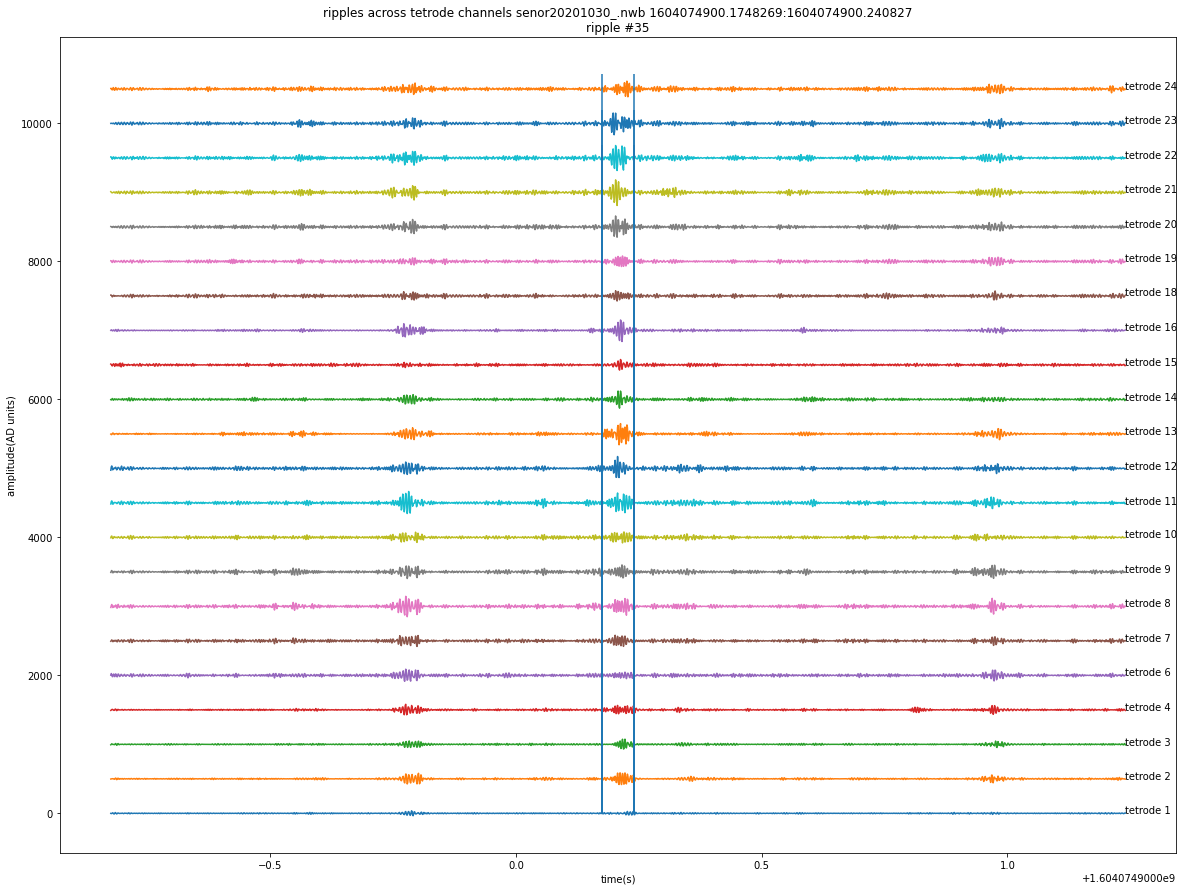

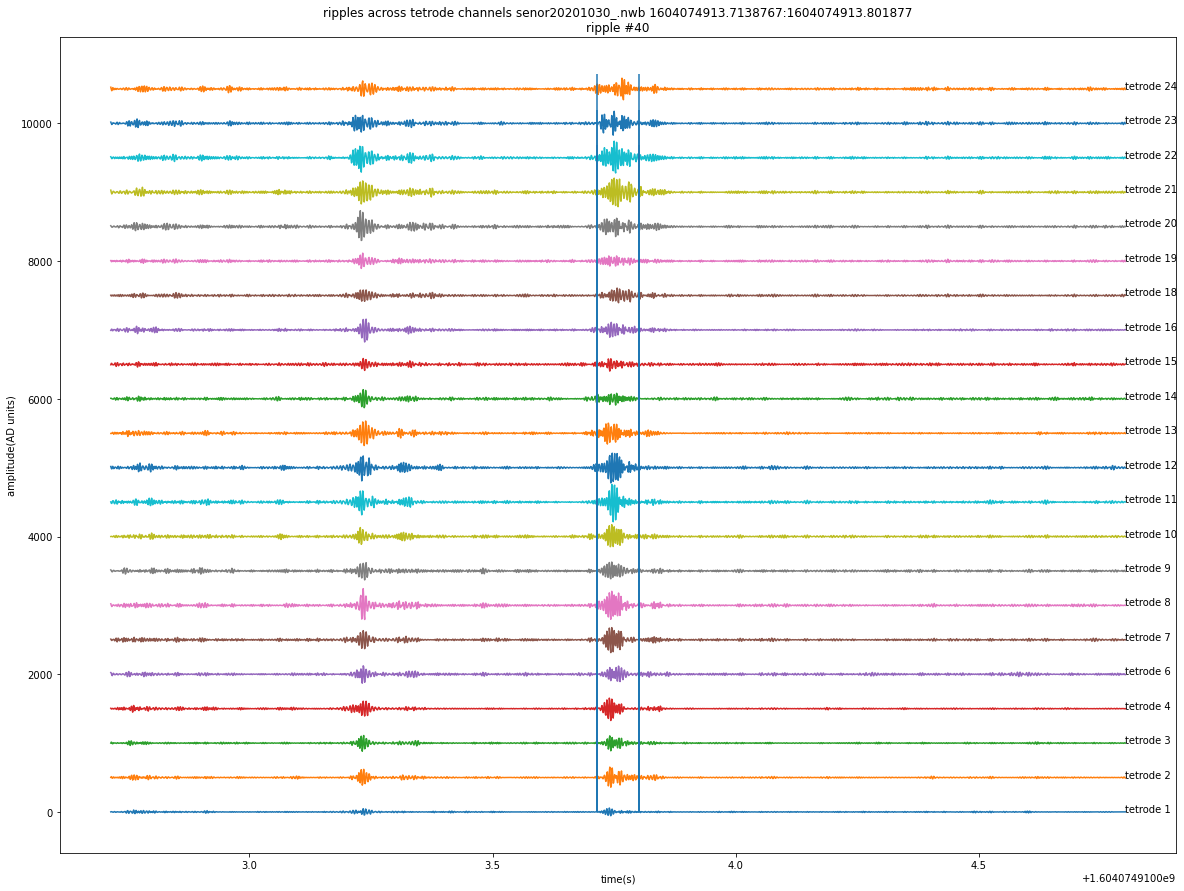

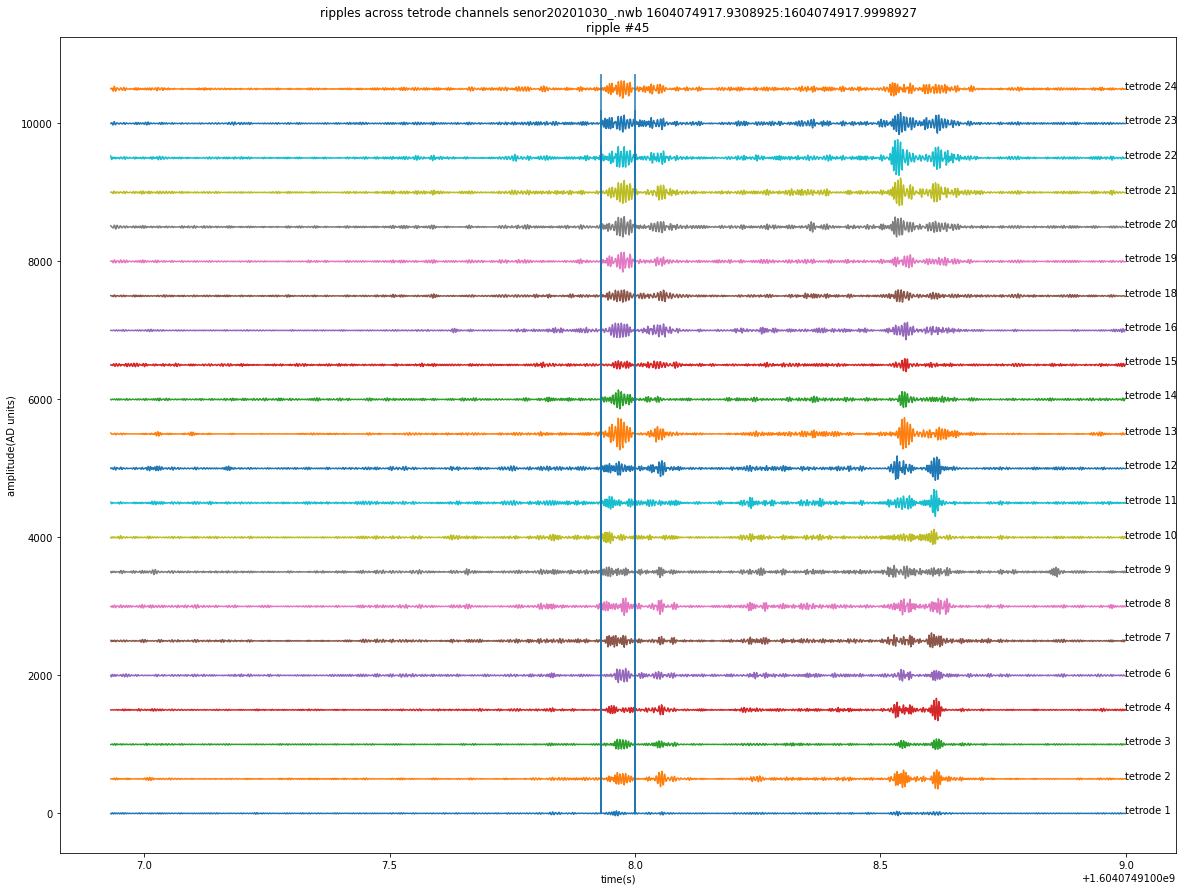

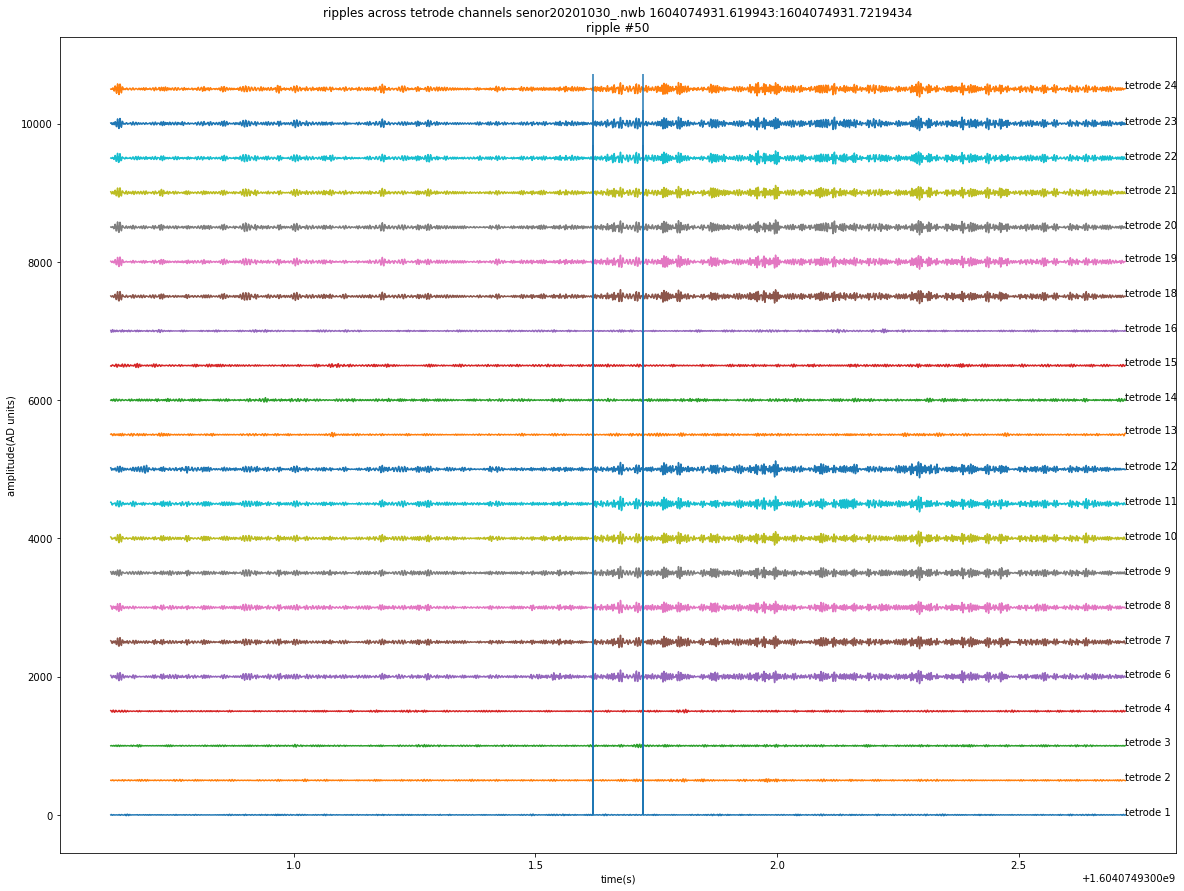

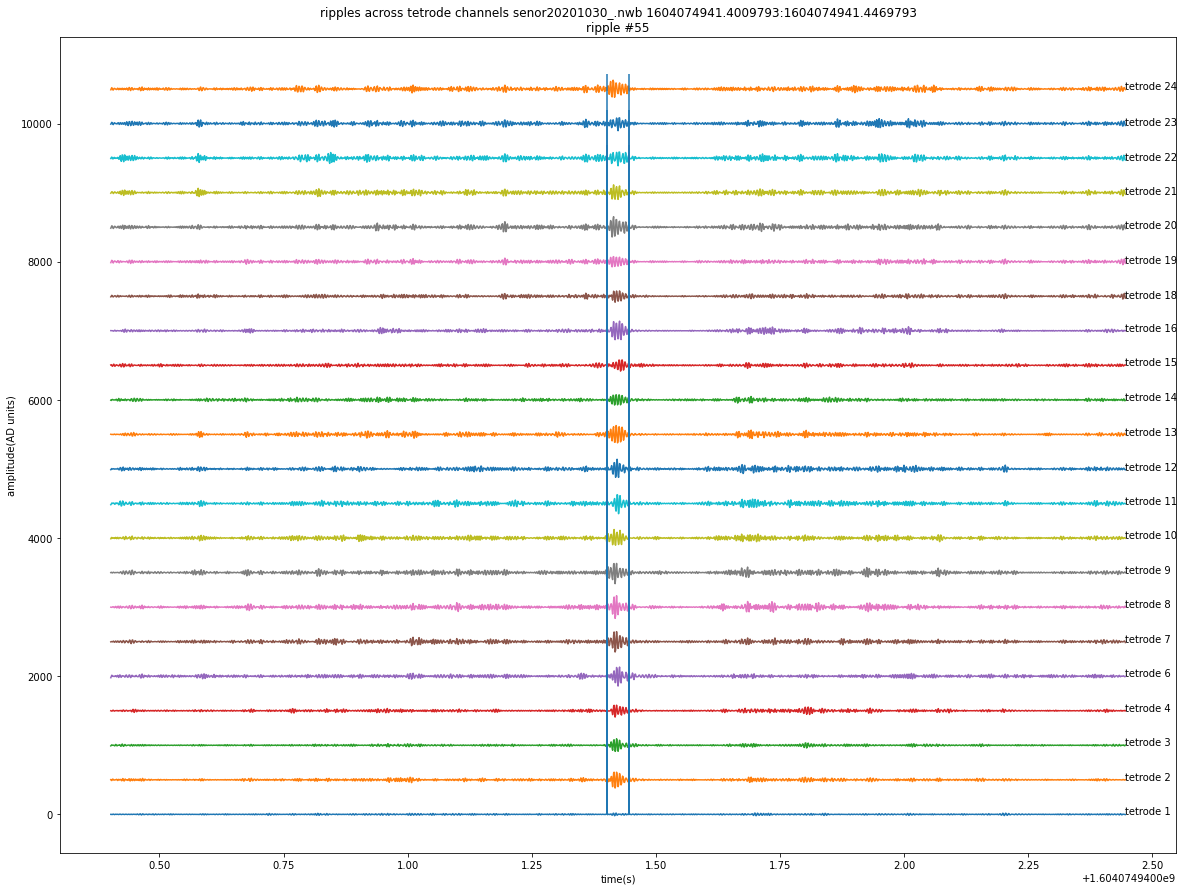

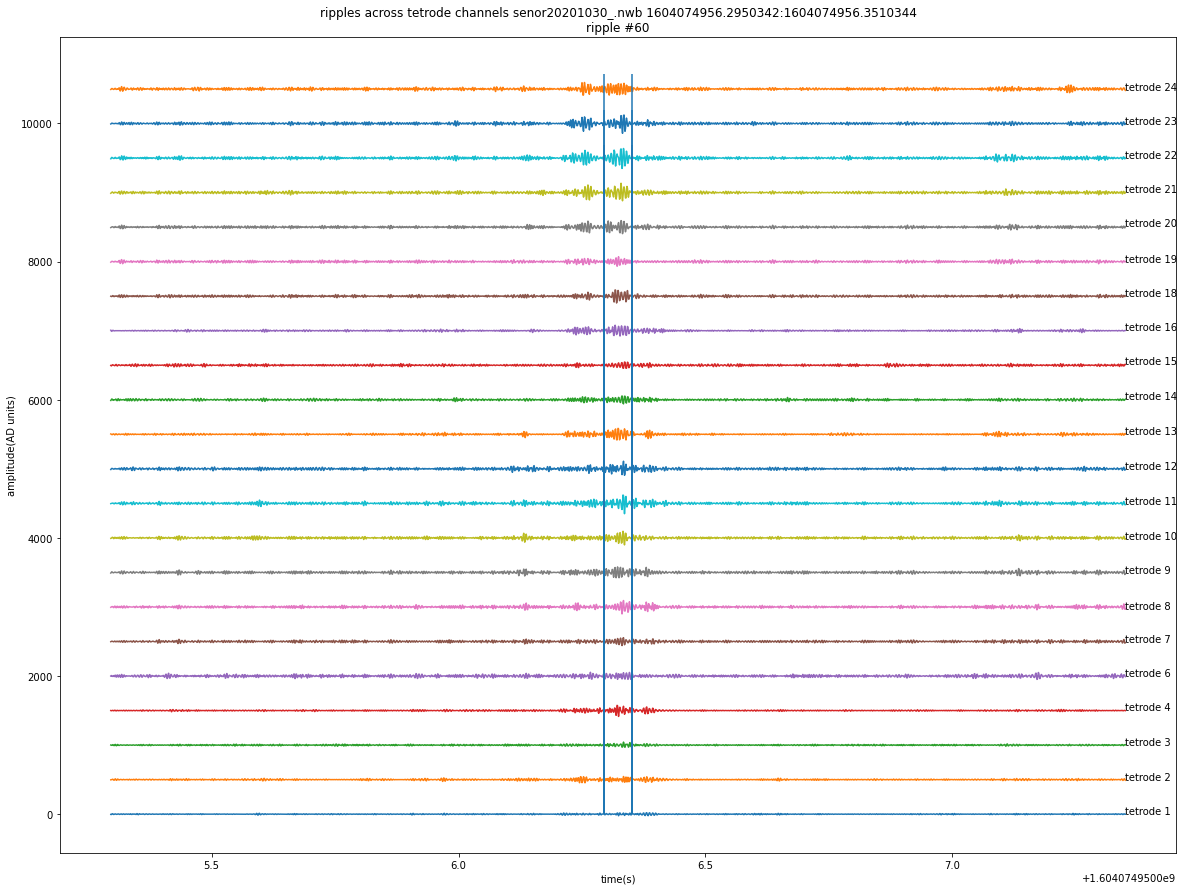

In [323]:
ripple_eseries = lfp_ripple_object['filtered_data']
ripple_data = ripple_eseries.data
ripple_timestamps = ripple_eseries.timestamps

ripple_num = [0,5,10,15,20,25,30,35,40,45,50, 55,60]
for rip in range(len(ripple_num)):

    plottimes = [ripple_times_df['start_time'].values[ripple_num[rip]], 
                 ripple_times_df['end_time'].values[ripple_num[rip]]]
    x_elect, y_elect= get_x_y_timestamp_list(plottimes[0], plottimes[1], ripple_elecs, ripple_eseries, ripple_timestamps, ripple_data)


    plt.figure(figsize=(20,15))
    for ix in range(len(x_elect)):
        plt.plot(x_elect[0],y_elect[ix]+500*ix,label=ripple_elecs[ix])
        plt.text(x_elect[0][-1], y_elect[ix][-1]+500*ix, f'tetrode {int(ripple_elecs[ix]/4)+1}')
        plt.title(f'ripples across tetrode channels {nwb_file_name} {plottimes[0]}:{plottimes[1]}\nripple #{ripple_num[rip]}')
        plt.xlabel('time(s)')
        plt.ylabel('amplitude(AD units)')
        plt.vlines(plottimes[0],0,510*ix)
        plt.vlines(plottimes[1],0,510*ix)
        
#

In [ ]:
#current problem: 
#though they are roughly the same length, and sampled at the same sampling rates, finding their intersection and masking 
#results in times that are slightly different between pos and lfp. 
#can mask them both with the same indicator, because its a different length. (to make sure they are using the same mask/times)
#but cant mask them individually because data sets are different lengths (even though technically the same times? 

#need a way of masking, or intelligently removing select times to make them the same length. 
